In [4]:
import numpy as np 
import pandas as pd
from datetime import date

# plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn
%matplotlib inline

#for linux use this
#RUTA_DATOS = '../datos_navent_fiuba/'
#and for windows use this
RUTA_DATOS = '../datos_navent_fiuba/'

In [5]:
#se cargan los datos
postulantes_educacion = pd.read_csv(RUTA_DATOS + 'fiuba_1_postulantes_educacion.csv')
pos_gen_edad = pd.read_csv(RUTA_DATOS + 'fiuba_2_postulantes_genero_y_edad.csv')
vistas = pd.read_csv(RUTA_DATOS + 'fiuba_3_vistas.csv')
postulaciones = pd.read_csv(RUTA_DATOS + 'fiuba_4_postulaciones.csv')
avisos_online = pd.read_csv(RUTA_DATOS + 'fiuba_5_avisos_online.csv')
avisos_detalle = pd.read_csv(RUTA_DATOS + 'fiuba_6_avisos_detalle.csv')


### Visualizacion inicial de los dataframes
Se procede a ver cada uno de los dataframes cargados junto con alguna de sus caracteriticas para analisar cual es la información que disponemos como punto de partida.

#### Postulantes_educacion

In [6]:
postulantes_educacion.head(5)

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


Podemos observar que tenemos ids de los postulantes y el nombre y el estado de su respectivo nivel educativo. Además observamos que un usuario puede tener más de un nivel educativo.

In [7]:
postulantes_educacion.shape

(298231, 3)

In [8]:
postulantes_educacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298231 entries, 0 to 298230
Data columns (total 3 columns):
idpostulante    298231 non-null object
nombre          298231 non-null object
estado          298231 non-null object
dtypes: object(3)
memory usage: 6.8+ MB


In [9]:
postulantes_educacion['nombre'].value_counts()

Secundario           110256
Universitario        104295
Terciario/Técnico     47733
Otro                  24748
Posgrado               7387
Master                 3598
Doctorado               214
Name: nombre, dtype: int64

In [10]:
postulantes_educacion['estado'].value_counts()

Graduado      194474
En Curso       78531
Abandonado     25226
Name: estado, dtype: int64

In [11]:
postulantes_educacion.drop_duplicates('idpostulante').shape

(188752, 3)

Como vemos, la cantidad real de usuarios sobre la que se tiene información acerca de su nivel o niveles educativos son 188752.

In [12]:
#se observa que nombre y estado son valores categoricos
#genera problemas mas adelante
#postulantes_educacion['estado'] = postulantes_educacion['estado'].astype('category')
#postulantes_educacion['nombre'] = postulantes_educacion['nombre'].astype('category')

In [13]:
pd.crosstab(postulantes_educacion.nombre, postulantes_educacion.estado)

estado,Abandonado,En Curso,Graduado
nombre,,,
Doctorado,15,94,105
Master,144,1519,1935
Otro,947,4919,18882
Posgrado,317,2239,4831
Secundario,3156,3995,103105
Terciario/Técnico,5692,15032,27009
Universitario,14955,50733,38607


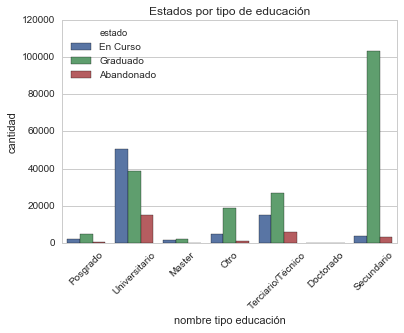

In [14]:
g = sns.countplot(x= 'nombre', hue= 'estado', data = postulantes_educacion)
g.set_title('Estados por tipo de educación')
g.set_xlabel('nombre tipo educación')
g.set_ylabel('cantidad')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)

#### Postulantes_gen_y_edad

In [15]:
pos_gen_edad.head(5)

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,5awk,1962-12-04,FEM
2,ZaO5,1978-08-10,FEM
3,NdJl,1969-05-09,MASC
4,eo2p,1981-02-16,MASC


Podemos observar que tenemos ids de los postulantes, su fecha de nacimiento y su respectivo genero.

In [16]:
pos_gen_edad.shape

(200888, 3)

Podemos observar que la cantidad de postulantes sobre la que se tiene esta información (200888) es mayor a la que se tiene el nivel educativo (188752).

In [17]:
pos_gen_edad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200888 entries, 0 to 200887
Data columns (total 3 columns):
idpostulante       200888 non-null object
fechanacimiento    196138 non-null object
sexo               200888 non-null object
dtypes: object(3)
memory usage: 4.6+ MB


Existen postulantes sobre los que no tenemos información de su edad

In [18]:
#se observa que sexo son valores categoricos y fechanacimiento fechas

pos_gen_edad['fechanacimiento'] = pd.to_datetime(pos_gen_edad['fechanacimiento'], errors = 'coerce', format= '%Y-%m-%d')
pos_gen_edad['sexo'] = pos_gen_edad['sexo'].astype('category')

In [19]:
pos_gen_edad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200888 entries, 0 to 200887
Data columns (total 3 columns):
idpostulante       200888 non-null object
fechanacimiento    196131 non-null datetime64[ns]
sexo               200888 non-null category
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 3.3+ MB


Vemos que existian 7 datos (196138-196131) que tenian fechas de nacimiento en formato incorrecto.

In [20]:
pos_gen_edad = pos_gen_edad[~(pos_gen_edad['fechanacimiento'].isnull())]

In [21]:
pos_gen_edad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196131 entries, 0 to 200886
Data columns (total 3 columns):
idpostulante       196131 non-null object
fechanacimiento    196131 non-null datetime64[ns]
sexo               196131 non-null category
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 4.7+ MB


In [22]:
pos_gen_edad['sexo'].value_counts()

FEM           101674
MASC           94013
NO_DECLARA       444
Name: sexo, dtype: int64

La cantidad de datos acerca de hombres y mujeres que poseemos es aproximadamente la misma.

In [23]:
today = date.today()
fechas = pos_gen_edad['fechanacimiento']
pos_gen_edad['edad'] = fechas.map(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
pos_gen_edad.head(5)

,idpostulante,fechanacimiento,sexo,edad
0,NM5M,1970-12-03,FEM,47
1,5awk,1962-12-04,FEM,55
2,ZaO5,1978-08-10,FEM,39
3,NdJl,1969-05-09,MASC,48
4,eo2p,1981-02-16,MASC,37


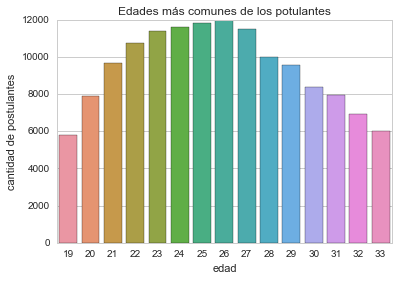

In [24]:
edades = pos_gen_edad['edad'].value_counts()[:15]
g = sns.barplot(x= edades.index, y=edades.values, orient= 'v')
g.set_title('Edades más comunes de los potulantes')
g.set_xlabel('edad')
g.set_ylabel('cantidad de postulantes')

In [25]:
#filtro edades que no tienen demaciado sentido en esta página
pos_gen_edad = pos_gen_edad[pos_gen_edad['edad'] < 65]
pos_gen_edad = pos_gen_edad[16 <= pos_gen_edad['edad']]

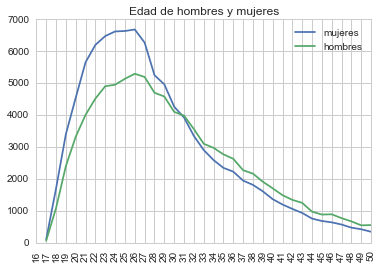

In [26]:
edades_masc = pos_gen_edad[(pos_gen_edad['sexo'] == 'MASC') & (pos_gen_edad['edad'] <= 50) ]['edad'].value_counts().sort_index()
edades_fem = pos_gen_edad[(pos_gen_edad['sexo'] == 'FEM') & (pos_gen_edad['edad'] <= 50) ]['edad'].value_counts().sort_index()
plt.figure()
edades_fem.plot(rot = 90, xticks = range(16,51), label = 'mujeres');
edades_masc.plot(rot = 90, xticks = range(16,51), label = 'hombres');
plt.title('Edad de hombres y mujeres')
plt.legend();

#### Vistas

In [27]:
vistas.tail(5)

,idAviso,timestamp,idpostulante
961892,1112366944,2018-02-28T23:59:08.772-0500,MVPj3AK
961893,1001442844,2018-02-28T23:59:37.000-0500,VNrYP6m
961894,1112362644,2018-02-28T23:59:46.181-0500,owzLD43
961895,1112305277,2018-02-28T23:59:52.754-0500,A3DraY1
961896,1112345900,2018-02-28T23:59:55.409-0500,ekmNzBW


Aquí encontramos las vistas que tuvo un aviso idAviso por el postulante idpostulante

In [28]:
vistas.shape

(961897, 3)

In [29]:
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null object
idpostulante    961897 non-null object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


In [30]:
vistas['timestamp'] = pd.to_datetime(vistas['timestamp'], errors = 'coerce', format = "%Y-%m-%dT%H:%M:%S.%f-0500")

In [31]:
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null datetime64[ns]
idpostulante    961897 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.0+ MB


In [32]:
vistas.tail()

,idAviso,timestamp,idpostulante
961892,1112366944,2018-02-28 23:59:08.772,MVPj3AK
961893,1001442844,2018-02-28 23:59:37.000,VNrYP6m
961894,1112362644,2018-02-28 23:59:46.181,owzLD43
961895,1112305277,2018-02-28 23:59:52.754,A3DraY1
961896,1112345900,2018-02-28 23:59:55.409,ekmNzBW


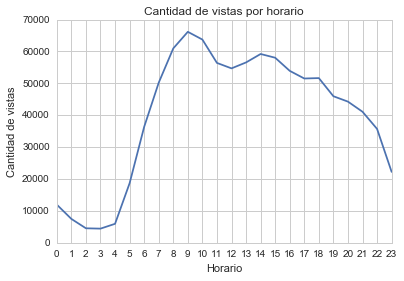

In [33]:
horarios = vistas['timestamp'].dt.hour.value_counts().sort_index()
g = horarios.plot(xticks= range(0,24))
g.set_title('Cantidad de vistas por horario')
g.set_xlabel('Horario')
g.set_ylabel('Cantidad de vistas')

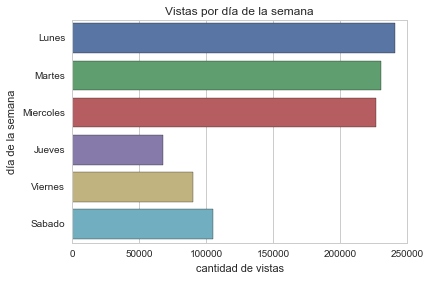

In [34]:
weekdays = vistas['timestamp'].map(lambda x: x.weekday()).value_counts()
g = sns.barplot(x= weekdays.values, y= weekdays.index, orient ='h')
g.set_title('Vistas por día de la semana')
g.set_xlabel('cantidad de vistas')
g.set_ylabel('día de la semana')
g.set_yticklabels(('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado','Domingo'))

#### Postulaciones

In [35]:
postulaciones.head(5)

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [36]:
postulaciones.shape

(3401623, 3)

In [37]:
postulaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB


In [38]:
postulaciones['fechapostulacion'] = pd.to_datetime(postulaciones['fechapostulacion'],errors = 'coerce', format = "%Y-%m-%d %H:%M:%S")

In [39]:
#promedio de postulaciones por usuario
postulantes = postulaciones['idpostulante'].value_counts()
postulantes.describe()

count    200888.000000
mean         16.932933
std          31.267385
min           1.000000
25%           3.000000
50%           8.000000
75%          19.000000
max        3166.000000
Name: idpostulante, dtype: float64

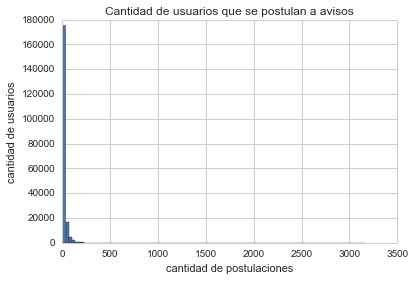

In [40]:
g = postulantes.hist(bins=100)
g.set_title('Cantidad de usuarios que se postulan a avisos')
g.set_xlabel('cantidad de postulaciones')
g.set_ylabel('cantidad de usuarios')

Filtramos porque como vemos muy pocos usuarios se han postulado a muchisimos avisos.

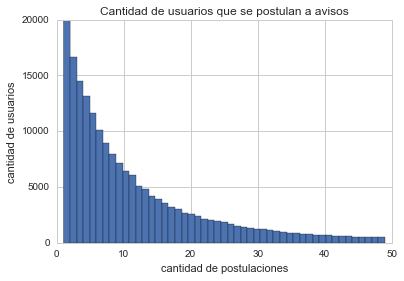

In [41]:
postulantes_filt = postulantes[postulantes.values < 50]
g = postulantes_filt.hist(bins=49)
g.set_title('Cantidad de usuarios que se postulan a avisos')
g.set_xlabel('cantidad de postulaciones')
g.set_ylabel('cantidad de usuarios')

In [42]:
pos_por_aviso = postulaciones['idaviso'].value_counts()
pos_por_aviso.describe()

count    12692.000000
mean       268.013158
std        542.269598
min          1.000000
25%         33.000000
50%        100.000000
75%        269.250000
max       9932.000000
Name: idaviso, dtype: float64

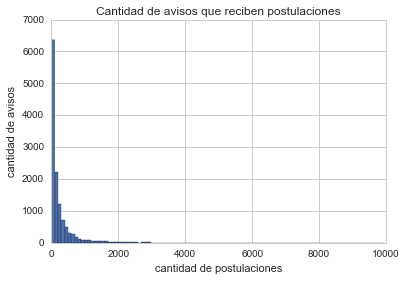

In [43]:
g = pos_por_aviso.hist(bins=100)
g.set_title('Cantidad de avisos que reciben postulaciones')
g.set_xlabel('cantidad de postulaciones')
g.set_ylabel('cantidad de avisos')

De igual manera, muy poca cantidad de avisos reciben varios miles de postulaciones más que el resto.

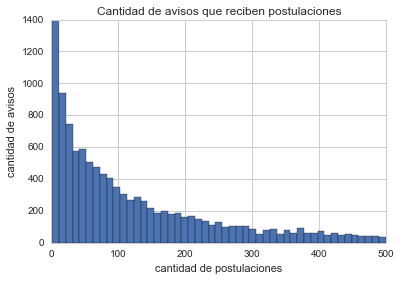

In [44]:
pos_por_aviso_filt = pos_por_aviso[pos_por_aviso.values < 500]
g = pos_por_aviso_filt.hist(bins=49)
g.set_title('Cantidad de avisos que reciben postulaciones')
g.set_xlabel('cantidad de postulaciones')
g.set_ylabel('cantidad de avisos')

In [45]:
postulaciones['fechapostulacion'].dt.month.value_counts()

2    2125425
1    1276198
Name: fechapostulacion, dtype: int64

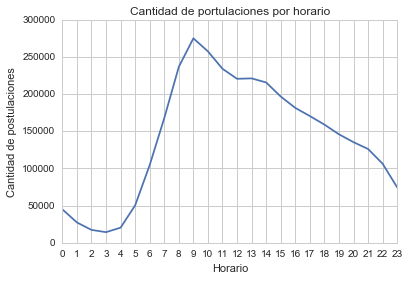

In [46]:
horarios = postulaciones['fechapostulacion'].dt.hour.value_counts().sort_index()
g = horarios.plot(xticks= range(0,24))
g.set_title('Cantidad de portulaciones por horario')
g.set_xlabel('Horario')
g.set_ylabel('Cantidad de postulaciones')

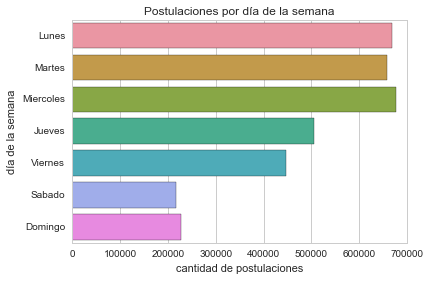

In [47]:
weekdays = postulaciones['fechapostulacion'].map(lambda x: x.weekday())
weekdays_count = weekdays.value_counts()
g = sns.barplot(x= weekdays_count.values, y= weekdays_count.index, orient ='h')
g.set_title('Postulaciones por día de la semana')
g.set_xlabel('cantidad de postulaciones')
g.set_ylabel('día de la semana')
g.set_yticklabels(('Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado','Domingo'))

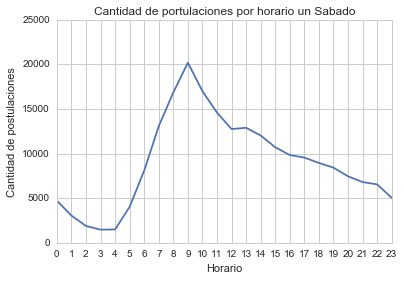

In [48]:
sabados = (weekdays.values == 5)
horarios_sabados = (postulaciones[sabados])['fechapostulacion'].dt.hour.value_counts().sort_index()
g = horarios_sabados.plot(xticks= range(0,24))
g.set_title('Cantidad de portulaciones por horario un Sabado')
g.set_xlabel('Horario')
g.set_ylabel('Cantidad de postulaciones')

Como vemos, un día como un sabado responde al mismo patron de postulaciones por horario que el resto de los dias.

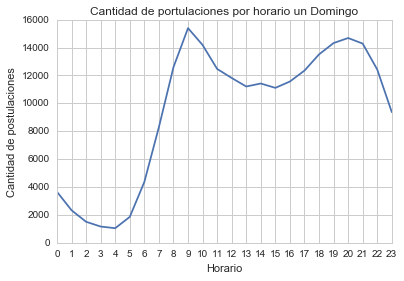

In [49]:
domingos = (weekdays.values == 6)
horarios_domingos = (postulaciones[domingos])['fechapostulacion'].dt.hour.value_counts().sort_index()
g = horarios_domingos.plot(xticks= range(0,24))
g.set_title('Cantidad de portulaciones por horario un Domingo')
g.set_xlabel('Horario')
g.set_ylabel('Cantidad de postulaciones')

Mientras que los domingos tienen un patrón distinto, esperable si consideramos que el estilo de vida de gente varia drasticamente estos dias.

#### avisos_online

In [50]:
avisos_online.head(5)

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [51]:
avisos_online.shape

(5028, 1)

Aquí podemos ver los avisos online al 8 de marzo de 2018

#### avisos_detalle

In [52]:
avisos_detalle.head(5)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,1,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,1,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


In [53]:
avisos_detalle.shape

(13534, 11)

In [54]:
avisos_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13534 entries, 0 to 13533
Data columns (total 11 columns):
idaviso                 13534 non-null int64
idpais                  13534 non-null int64
titulo                  13534 non-null object
descripcion             13534 non-null object
nombre_zona             13534 non-null object
ciudad                  47 non-null object
mapacalle               872 non-null object
tipo_de_trabajo         13534 non-null object
nivel_laboral           13534 non-null object
nombre_area             13534 non-null object
denominacion_empresa    13529 non-null object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


In [55]:
#ESTO NO LO USO XQ ME JODE AL USAR LOC
# Columnas que se detecto que son variables categoricas
#avisos_detalle['nombre_zona'] = avisos_detalle['nombre_zona'].astype('category')
#avisos_detalle['tipo_de_trabajo'] = avisos_detalle['tipo_de_trabajo'].astype('category')
#avisos_detalle['nivel_laboral'] = avisos_detalle['nivel_laboral'].astype('category')
#avisos_detalle['nombre_area'] = avisos_detalle['nombre_area'].astype('category')                                                                             

In [56]:
avisos_detalle["nombre_zona"].value_counts()

Gran Buenos Aires              12654
Capital Federal                  876
GBA Oeste                          2
Buenos Aires (fuera de GBA)        2
Name: nombre_zona, dtype: int64

In [57]:
caba=((avisos_detalle.loc[avisos_detalle['nombre_zona'] == "Capital Federal"  ])["nombre_area"]).value_counts().head(5)
gba =((avisos_detalle.loc[avisos_detalle['nombre_zona'] == "Gran Buenos Aires"])["nombre_area"]).value_counts().head(5)

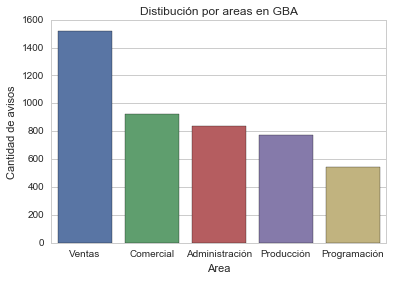

In [58]:
g = sns.barplot(y=gba.values, x=gba.index, orient='v')
g.set_title('Distibución por areas en GBA')
g.set_xlabel('Area')
g.set_ylabel('Cantidad de avisos')

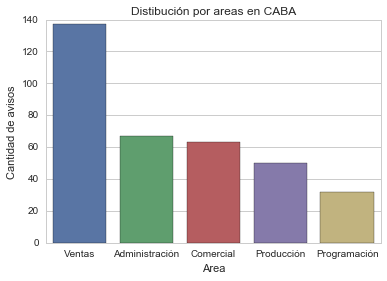

In [59]:
g = sns.barplot(y=caba.values, x=caba.index, orient='v')
g.set_title('Distibución por areas en CABA')
g.set_xlabel('Area')
g.set_ylabel('Cantidad de avisos')

Vemos que las areas con más publicaciones coinciden y, apesar de que la cantidad difieren mucho, viendo los gráficos podemos que la relación entre las areas es similar en ambas zonas.

In [60]:
avisos_detalle["denominacion_empresa"].value_counts().describe()

count    2592.000000
mean        5.219522
std        22.328432
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       562.000000
Name: denominacion_empresa, dtype: float64

Observamos que la mayoria de las empresas tiene pocos avisos, mientras que unas pocas son las que tienen gran cantidad de avisos.

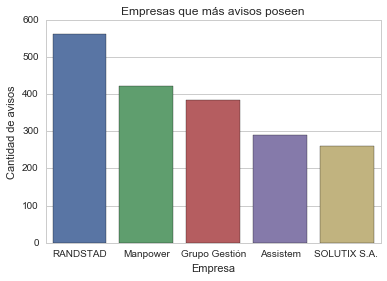

In [61]:
top_5= avisos_detalle["denominacion_empresa"].value_counts()[:5]
g = sns.barplot(x=top_5.index, y = top_5.values, orient = 'v')
g.set_title('Empresas que más avisos poseen')
g.set_xlabel('Empresa')
g.set_ylabel('Cantidad de avisos')

https://www.randstad.com.ar/
https://www.manpowergroup.com.ar/
https://www.grupo-gestion.com.ar/
http://www.assistem.com.ar/
http://www.solutix.com.ar/
Detalle bastante peculiar, las empresas que tienen más avisos publicados son justamente empresas que se encargan de las mismas tareas que zonaJobs, enlazar personas con empresas en busca de trabajo. ¿Por qué no utilizan sus propias páginas para buscar sus empleados? ¿O acaso republican sus avisos en otra pagina como zonaJobs?

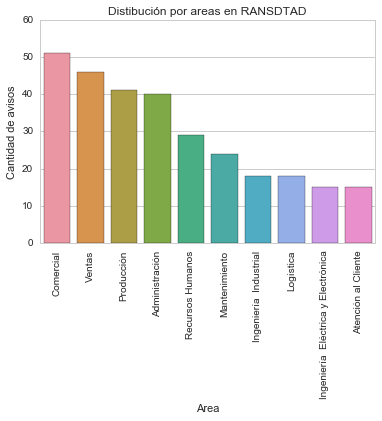

In [62]:
empleos = avisos_detalle[avisos_detalle['denominacion_empresa'] == "RANDSTAD"]['nombre_area'].value_counts()[:10]
g = sns.barplot(x=empleos.index, y = empleos.values, orient = 'v')
g.set_title('Distibución por areas en RANSDTAD')
g.set_xlabel('Area')
g.set_ylabel('Cantidad de avisos')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

Como vemos, los avisos de Randstad son en areas bastante variadas, lo cual nos hace pensar que si es posible que sus avisos sean republicados en zonaJobs.

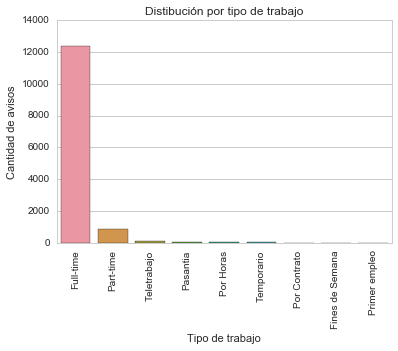

In [63]:
tipo_de_trabajo = avisos_detalle["tipo_de_trabajo"].value_counts()
g = sns.barplot(x=tipo_de_trabajo.index, y = tipo_de_trabajo.values, orient = 'v')
g.set_title('Distibución por tipo de trabajo')
g.set_xlabel('Tipo de trabajo')
g.set_ylabel('Cantidad de avisos')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

In [64]:
tipo_de_trabajo

Full-time          12339
Part-time            863
Teletrabajo          110
Pasantia              63
Por Horas             63
Temporario            42
Por Contrato          37
Fines de Semana       14
Primer empleo          3
Name: tipo_de_trabajo, dtype: int64

In [65]:
avisos_detalle["nivel_laboral"].value_counts()

Senior / Semi-Senior                    9407
Junior                                  2216
Otro                                     921
Jefe / Supervisor / Responsable          809
Gerencia / Alta Gerencia / Dirección     181
Name: nivel_laboral, dtype: int64

Aunque los datos de nivel laboral no son muy precisos ya que aparentemente es un campo obligatorio a la hora de generar un aviso y por eso encontramos caso como Chofer de taxi Senior cuando no tiene ningun sentido.

### Edad vs nivel educativo

In [66]:
postulantes_graduados = postulantes_educacion[postulantes_educacion['estado'] == 'Graduado']
postulantes_graduados = pd.crosstab(postulantes_graduados.idpostulante, postulantes_graduados.nombre)
postulantes_graduados.head()

nombre,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
idpostulante,,,,,,,
0z5VvGv,0,0,0,0,1,0,0
0zB026d,0,0,0,0,1,1,0
0zB03O9,0,0,0,0,1,0,0
0zB08lq,0,0,0,0,1,0,0
0zB0NWY,0,0,0,0,0,0,1


In [ ]:
doctores = postulantes_graduados[postulantes_graduados['Doctorado'] == 1]
#analisis de doctores
postulantes_graduados.drop(postulantes_graduados[postulantes_graduados['Doctorado'] == 1])

In [67]:
postulantes_graduados = postulantes_graduados.reset_index()

In [68]:
postulantes_graduados_edad = pd.merge(postulantes_graduados, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
postulantes_graduados_edad.head()

,idpostulante,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario,edad
0,0z5VvGv,0,0,0,0,1,0,0,30
1,0zB026d,0,0,0,0,1,1,0,40
2,0zB03O9,0,0,0,0,1,0,0,30
3,0zB08lq,0,0,0,0,1,0,0,45
4,0zB0NWY,0,0,0,0,0,0,1,30


In [69]:
graduados_por_edad = postulantes_graduados_edad.groupby('edad').aggregate(sum)
graduados_por_edad.head()

,Doctorado,Master,Otro,Posgrado,Secundario,Terciario/Técnico,Universitario
edad,,,,,,,
17,0,0,3,0,76,1,1
18,1,0,109,5,1743,57,6
19,0,7,321,5,3812,199,28
20,4,4,558,23,5236,352,48
21,0,11,822,32,6410,680,167


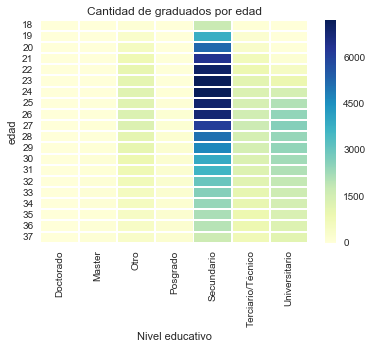

In [70]:
g = sns.heatmap(graduados_por_edad[1:21], cmap="YlGnBu", linewidths = 1)
g.set_title('Cantidad de graduados por edad')
g.set_xlabel('Nivel educativo')

Repetimos el proceso para los que estan en curso.

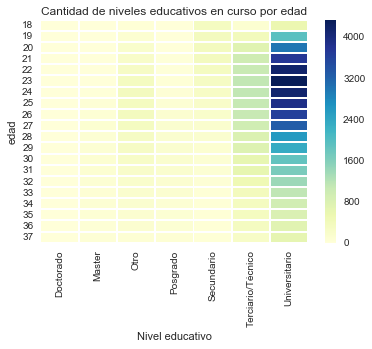

In [71]:
postulantes_en_curso = postulantes_educacion[postulantes_educacion['estado'] == 'En Curso']
postulantes_en_curso = pd.crosstab(postulantes_en_curso.idpostulante, postulantes_en_curso.nombre)
postulantes_en_curso = postulantes_en_curso.reset_index()
postulantes_en_curso_edad = pd.merge(postulantes_en_curso, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
en_curso_por_edad = postulantes_en_curso_edad.groupby('edad').aggregate(sum)
g = sns.heatmap(en_curso_por_edad[1:21], cmap="YlGnBu", linewidths = 1)
g.set_title('Cantidad de niveles educativos en curso por edad')
g.set_xlabel('Nivel educativo')

Hagamos un analisís aparte para solo Universitarios, un nivel educativo muy importante en el ambito laboral

In [72]:
postulantes_universitarios = postulantes_educacion[postulantes_educacion['nombre'] == 'Universitario']
postulantes_universitarios = pd.crosstab(postulantes_universitarios.idpostulante, postulantes_universitarios.estado)
postulantes_universitarios = postulantes_universitarios.reset_index()
postulantes_universitarios = pd.merge(postulantes_universitarios, pos_gen_edad[['idpostulante','edad']], on='idpostulante', how='inner')
universitarios_por_edad = postulantes_universitarios.groupby('edad').aggregate(sum)
universitarios_por_edad.head()


,Abandonado,En Curso,Graduado
edad,,,
17,0,22,1
18,18,562,6
19,93,1947,28
20,226,2989,48
21,394,3762,167


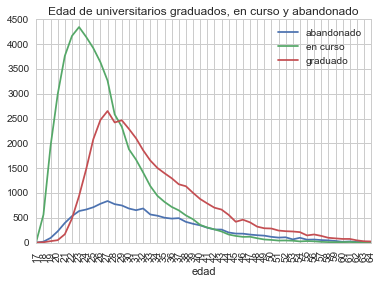

In [73]:
edades_abandonado = universitarios_por_edad['Abandonado']
edades_en_curso = universitarios_por_edad['En Curso']
edades_graduados = universitarios_por_edad['Graduado']
plt.figure()
edades_abandonado.plot(rot = 90, xticks = range(17,65), label = 'abandonado');
edades_en_curso.plot(rot = 90, xticks = range(17,65), label = 'en curso');
edades_graduados.plot(rot = 90, xticks = range(17,65), label = 'graduado');
plt.title('Edad de universitarios graduados, en curso y abandonado')
plt.legend();

### Agregando el sexo a este analisis

In [74]:
def nombre_to_num(nombre):
    dicc = {'Doctorado': 1,'Master':2, 'Otro':3, 'Posgrado':4, 'Secundario':5, 'Terciario/Técnico':6, 'Universitario':7}
    return dicc[nombre]

In [75]:
postulantes_en_curso = postulantes_educacion[postulantes_educacion['estado'] == 'En Curso']

In [76]:
postulantes_en_curso_edad_sexo = pd.merge(postulantes_en_curso[['idpostulante','nombre']], pos_gen_edad[['idpostulante','edad','sexo']], on='idpostulante', how='inner')
postulantes_en_curso_edad_sexo.head()

,idpostulante,nombre,edad,sexo
0,NdJl,Posgrado,48,MASC
1,8BkL,Universitario,41,FEM
2,1d2B,Universitario,42,MASC
3,NPBx,Universitario,37,MASC
4,NPBx,Master,37,MASC


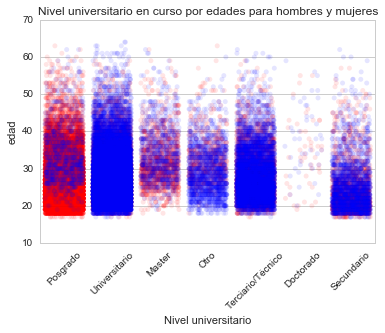

In [77]:
mujeres = postulantes_en_curso_edad_sexo[postulantes_en_curso_edad_sexo['sexo'] == 'FEM']
hombres = postulantes_en_curso_edad_sexo[postulantes_en_curso_edad_sexo['sexo'] == 'MASC']
g = sns.stripplot(x="nombre", y="edad", data=mujeres,alpha=0.1, jitter=0.4, color = 'r')
g = sns.stripplot(x="nombre", y="edad", data=hombres,alpha=0.1, jitter=0.4, color = 'b')
g.set_title('Nivel universitario en curso por edades para hombres y mujeres');
g.set_xlabel('Nivel universitario');
g.set_xticklabels(g.get_xticklabels(), rotation = 45);

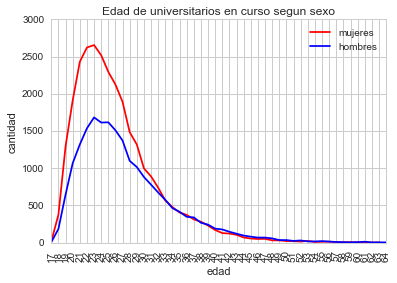

In [78]:
mujeres_universitarias = mujeres[mujeres['nombre'] == 'Universitario']
hombres_universitarios = hombres[hombres['nombre'] == 'Universitario']
edades_mujeres_universitarias = mujeres_universitarias['edad'].value_counts().sort_index()
edades_hombres_universitarios = hombres_universitarios['edad'].value_counts().sort_index()
plt.figure()
f = edades_mujeres_universitarias.plot(rot = 90, xticks = range(17,65), label = 'mujeres', color='r');
f = edades_hombres_universitarios.plot(rot = 90, xticks = range(17,65), label = 'hombres', color = 'b');
plt.title('Edad de universitarios en curso segun sexo')
f.set_xlabel('edad')
f.set_ylabel('cantidad')
plt.legend();